### Ce-bigFISH Image Analysis in batch

### 240112

# Code now creates a new image_output_directory for every image and saves image_colors and segmentation.

Now I need to save threshold and spot detection output here also -> image_output_directory

Not iterating through the subdirectories. Image-01 threshold and SD are storing in 11
also need to specify the RNA channel that is being detected. This is why we have an output code in the function plus when calling it. 

#### Input image info:

In [1]:
import os
import shutil
import bigfish.stack as stack



#import packages:
import os
import matplotlib.pyplot as plt
import numpy as np

import tifffile
import bigfish
import bigfish.stack as stack
import bigfish.plot as plot
import bigfish.multistack as multistack
import bigfish.detection as detection

import cellpose
from cellpose import models
# from cellpose import plot
import pandas as pd
import skimage
from skimage.measure import label, regionprops
from skimage.morphology import square, dilation, erosion
from skimage import measure, morphology
from skimage import measure

from IPython.display import display
import seaborn as sns


In [2]:
#specify where the directory of the data
local_download_directory = '/pl/active/onishimura_lab/PROJECTS/naly/bigfish/02_DG_quantification/N2_lin-41_set-3/230521_N2_lin-41_set-3_rep1/230521_N2_lin-41_set-3_rep1_4-cell'
#specify the molecules in each channel
Cy5 = "set-3 mRNA" #(asymmetrical control)
mCherry = "lin-41 mRNA" #(query mRNA)
FITC = "LIN-41" #(ignore in this case) This is where protein markers usually go.
DAPI = "DAPI"


In [3]:
#Specify where the data will be stored
input_directory = os.path.join(local_download_directory, 'input')
output_directory = os.path.join(local_download_directory, 'output')

folder_name = local_download_directory.split(os.path.sep)[-1]

# Get a list of subdirectories within local_download_directory
subdirectories = [item for item in sorted(os.listdir(input_directory)) if item != '.ipynb_checkpoints' if os.path.isdir(os.path.join(input_directory, item))]

# Iterate through the subdirectories and store their path in a list
subdirectory_paths = []
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(input_directory, subdirectory)
    subdirectory_paths.append(subdirectory_path)

# Iterate through each subdirectory path
all_image_stacks = []
all_files = []
for subdirectory_path in subdirectory_paths:
    files = [os.path.join(subdirectory_path, item) for item in os.listdir(subdirectory_path)]
    
    # Check if exactly 2 files with the specified names are present
    if len(files) == 2 and any(file.endswith("R3D_REF.dv") for file in files) and any(file.endswith("R3D.dv") for file in files):
        files = sorted(files)
        all_files.append(files)
        
        # Store all image stacks in a list
        subdirectory_image_stacks = []
        for file_path in files:
            image_stack = stack.read_dv(file_path, sanity_check=False)
            subdirectory_image_stacks.append(image_stack)
        all_image_stacks.append(subdirectory_image_stacks)
        
    else:
        print(f"corrupted: {subdirectory_path}")
        # Copy the entire corrupted directory to the 'corrupted_files' directory
        corrupted_path = os.path.join(local_download_directory, 'corrupted_files')
        corrupted_subdirectory = os.path.basename(subdirectory_path)
        corrupted_destination = os.path.join(corrupted_path, corrupted_subdirectory)
        shutil.move(subdirectory_path, corrupted_destination)
        continue

# Now, all_image_stacks contains the image data from all the .dv files, organized by subdirectory.
print(f'Images read: {len(all_image_stacks)}')

image_names = []

for file_pair in all_files:
    for file_path in file_pair:
        # Extract the filename without extension
        filename = os.path.splitext(os.path.basename(file_path))[0]
        # Extract the part before the last underscore
        image_name = filename.rsplit('_', 0)[0]
        # Add the image_name to the list if it's not already present and does not end with '_REF'
        if image_name not in image_names and not image_name.endswith('_REF'):
            image_names.append(image_name)

print(image_names)

Images read: 4
['230521_N2_05_R3D', '230521_N2_06_R3D', '230521_N2_08_R3D', '230521_N2_11_R3D']


/pl/active/onishimura_lab/PROJECTS/naly/bigfish/02_DG_quantification/N2_lin-41_set-3/230521_N2_lin-41_set-3_rep1/230521_N2_lin-41_set-3_rep1_4-cell/input/05


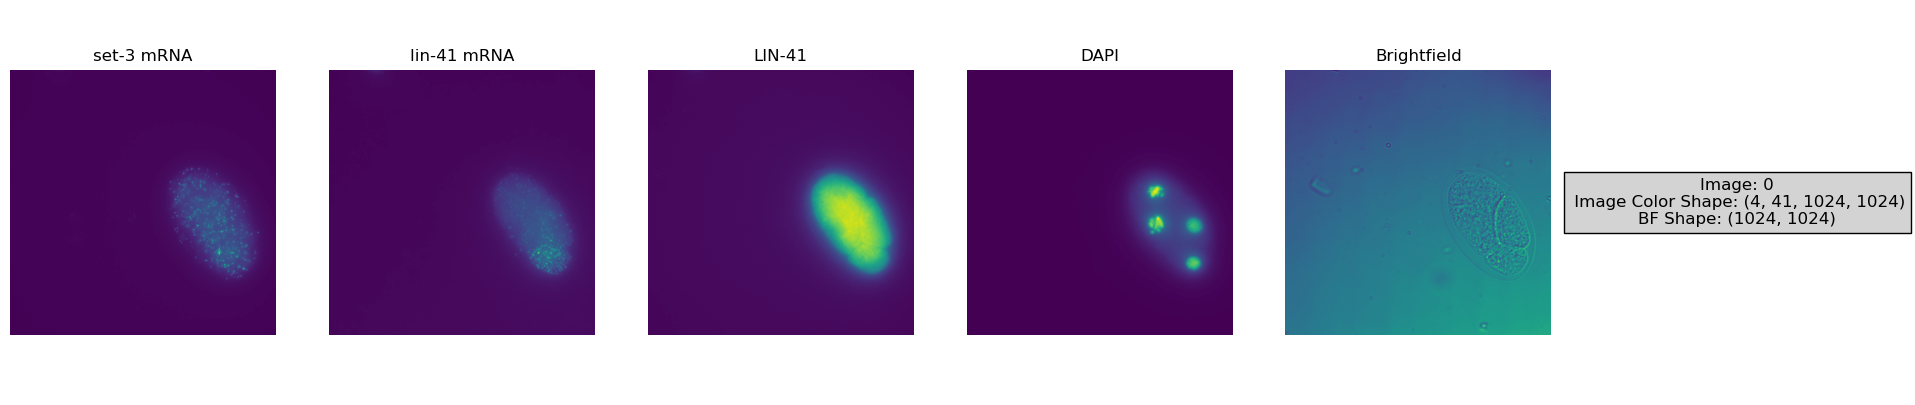

/pl/active/onishimura_lab/PROJECTS/naly/bigfish/02_DG_quantification/N2_lin-41_set-3/230521_N2_lin-41_set-3_rep1/230521_N2_lin-41_set-3_rep1_4-cell/input/06


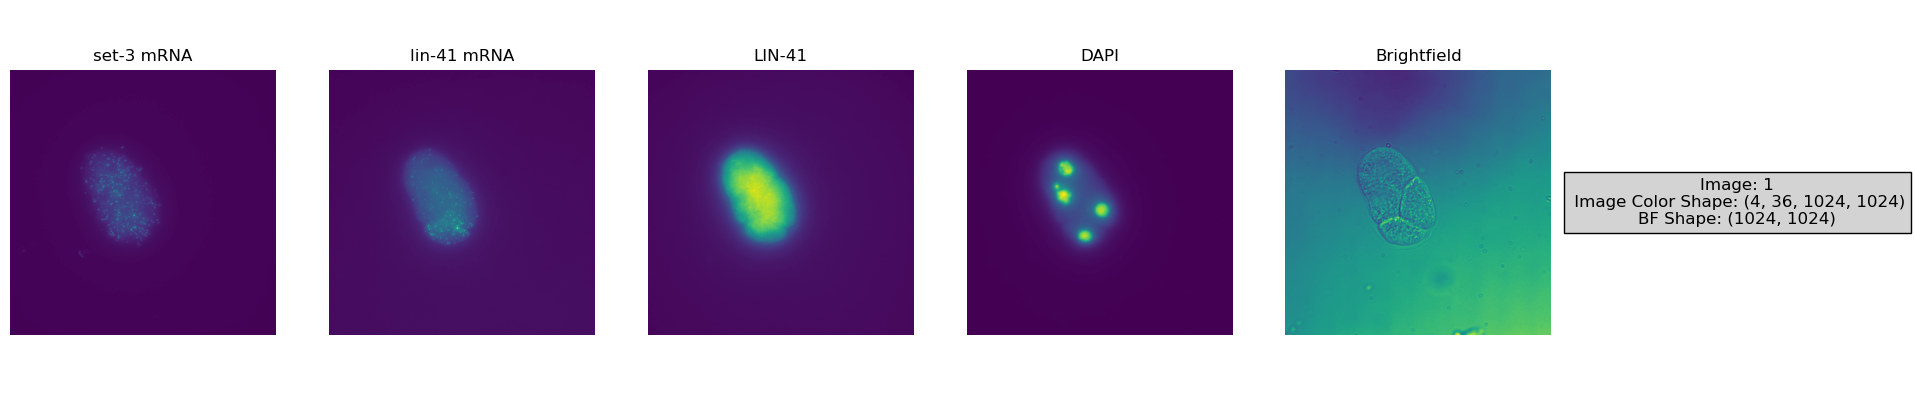

/pl/active/onishimura_lab/PROJECTS/naly/bigfish/02_DG_quantification/N2_lin-41_set-3/230521_N2_lin-41_set-3_rep1/230521_N2_lin-41_set-3_rep1_4-cell/input/08


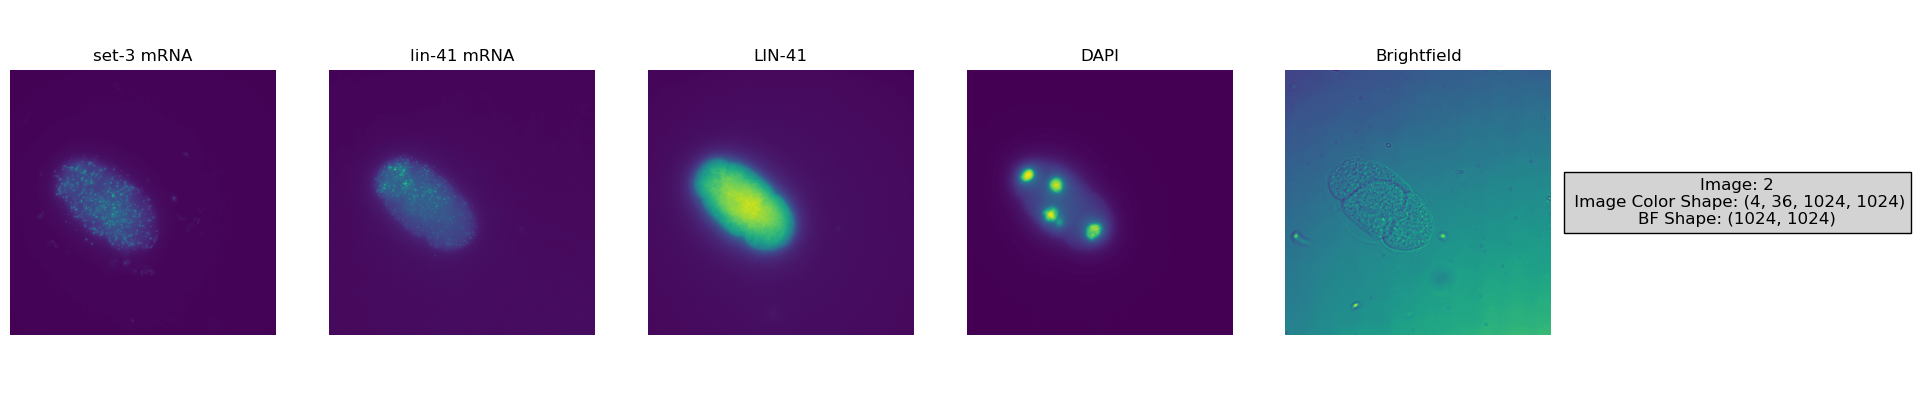

/pl/active/onishimura_lab/PROJECTS/naly/bigfish/02_DG_quantification/N2_lin-41_set-3/230521_N2_lin-41_set-3_rep1/230521_N2_lin-41_set-3_rep1_4-cell/input/11


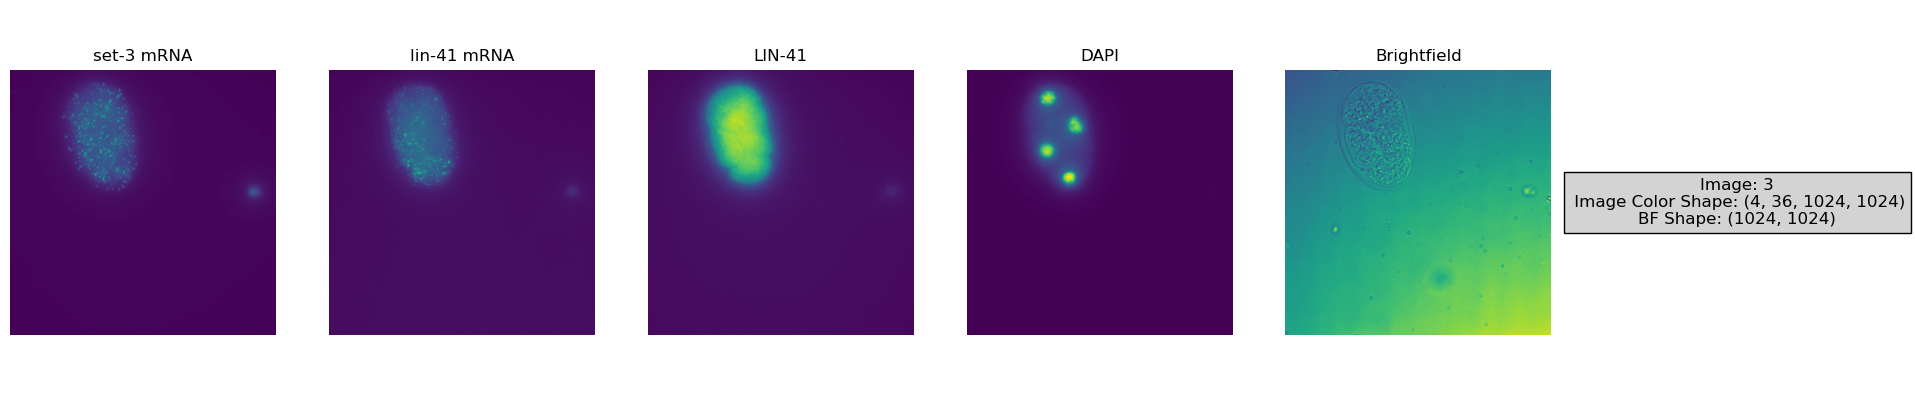

In [4]:
import matplotlib.pyplot as plt
import numpy as np

C0 = Cy5 #(asymmetrical control)
C1 = mCherry #(query mRNA)
C2 = FITC #(ignore in this case) This is where protein markers usually go.
C3 = DAPI


def plot_image(image_colors, bf, C0, C1, C2, C3, subdirectory_path):
    # Create subplots for each stack
    fig, ax = plt.subplots(1, 6, figsize=(24, 5))
    # Plotting the heatmap of a section in the image
    ax[0].imshow(np.max(image_colors[0,:,:,:], axis=0))
    ax[0].set_title(C0)
    ax[0].axis('off')
    
    print(subdirectory_path)

    ax[1].imshow(np.max(image_colors[1,:,:,:], axis=0))
    ax[1].set_title(C1)
    ax[1].axis('off')

    ax[2].imshow(np.max(image_colors[2,:,:,:], axis=0))
    ax[2].set_title(C2)
    ax[2].axis('off')

    ax[3].imshow(np.max(image_colors[3,:,:,:], axis=0))
    ax[3].set_title(C3)
    ax[3].axis('off')

    ax[4].imshow(bf[:,:])
    ax[4].set_title("Brightfield")
    ax[4].axis('off')
    
    # Add plot info as the 6th column  
    plot_info = f"Image: {i}\n Image Color Shape: {image_colors.shape}\nBF Shape: {bf.shape}"
    ax[5].text(0.5, 0.5, plot_info, ha='center', va='center', fontsize=12, color='black', bbox=dict(facecolor='lightgray'))
    ax[5].axis('off')  # Turn off the axis for this colum


image_output_directories = []
# Now iterate through all_image_stacks and call plot with the appropriate arguments

for i, stack_image in enumerate(all_image_stacks):
    #if i != 1:
        image_colors = all_image_stacks[i][0]
        bf = all_image_stacks[i][1]
        plot_image(image_colors, bf, C0, C1, C2, C3, subdirectory_paths[i])
        subdirectory = subdirectories[i]

        # Create image_output_directory. This is where all the output will end up going. 
        image_output_directory = os.path.join(output_directory, subdirectory)
        os.makedirs(image_output_directory, exist_ok=True)
        image_output_directories.append(image_output_directory)
        
        # Generate filename with subdirectory
        image_colors_filename = os.path.join(image_output_directory, f"{subdirectory}_image_colors.png")
    
        plt.savefig(image_colors_filename)
        plt.show()

#### 2.1 Segmentation

In [5]:
# Codes used to segment the nucleus and the cytosol

def remove_lonely_masks(masks_0, masks_1,is_nuc=None):
    n_mask_0 = np.max(masks_0)
    n_mask_1 = np.max(masks_1)
    if (n_mask_0>0) and (n_mask_1>0):
        for ind_0 in range(1,n_mask_0+1):
            tested_mask_0 = erosion(np.where(masks_0 == ind_0, 1, 0))
            array_paired= np.zeros(n_mask_1)
            for ind_1 in range(1,n_mask_1+1):
                tested_mask_1 = erosion(np.where(masks_1 == ind_1, 1, 0))
                array_paired[ind_1-1] = is_nucleus_in_cytosol(tested_mask_1, tested_mask_0)
                if (is_nuc =='nuc') and (np.count_nonzero(tested_mask_0) > np.count_nonzero(tested_mask_1) ):
                    # condition that rejects images with nucleus bigger than the cytosol
                    array_paired[ind_1-1] = 0
                elif (is_nuc is None ) and (np.count_nonzero(tested_mask_1) > np.count_nonzero(tested_mask_0) ):
                    array_paired[ind_1-1] = 0
            if any (array_paired) == False: # If the cytosol is not associated with any mask.
                masks_0 = np.where(masks_0 == ind_0, 0, masks_0)
            masks_with_pairs = masks_0
        else:
            masks_with_pairs = np.zeros_like(masks_0)
        return masks_with_pairs

def is_nucleus_in_cytosol(mask_n, mask_c):
    mask_n[mask_n>1]=1
    mask_c[mask_c>1]=1
    size_mask_n = np.count_nonzero(mask_n)
    size_mask_c = np.count_nonzero(mask_c)
    min_size =np.min( (size_mask_n,size_mask_c) )
    mask_combined =  mask_n + mask_c
    sum_mask = np.count_nonzero(mask_combined[mask_combined==2])
    if (sum_mask> min_size*0.8) and (min_size>200): # the element is inside if the two masks overlap over the 80% of the smaller mask.
        return 1
    else:
        return 0

def matching_masks(masks_cyto, masks_nuclei):
    n_mask_cyto = np.max(masks_cyto)
    n_mask_nuc = np.max(masks_nuclei)
    new_masks_nuclei = np.zeros_like(masks_cyto)
    reordered_mask_nuclei = np.zeros_like(masks_cyto)
    if (n_mask_cyto>0) and (n_mask_nuc>0):
        for mc in range(1,n_mask_cyto+1):
            tested_mask_cyto = np.where(masks_cyto == mc, 1, 0)
            for mn in range(1,n_mask_nuc+1):
                mask_paired = False
                tested_mask_nuc = np.where(masks_nuclei == mn, 1, 0)
                mask_paired = is_nucleus_in_cytosol(tested_mask_nuc, tested_mask_cyto)
                if mask_paired == True:
                    if np.count_nonzero(new_masks_nuclei) ==0:
                        new_masks_nuclei = np.where(masks_nuclei == mn, -mc, masks_nuclei)
                    else:
                        new_masks_nuclei = np.where(new_masks_nuclei == mn, -mc, new_masks_nuclei)
            reordered_mask_nuclei = np.absolute(new_masks_nuclei)

    return reordered_mask_nuclei


# def reorganize_cytosol_masks(masks):
#   if np.max(masks>1):
#     else:
#       reorganized_masks = mask


def segmentation(image_cytosol,image_nuclei, cytosol_diameter=80, threshold_intensity_nuc_segmentation=1200,cellpose_ts=1):
    color_map = 'Greys_r'
    
    # cytosol segmentation
    model = models.Cellpose(gpu=True, model_type='cyto2') # model_type='cyto', 'cyto2' or model_type='nuclei'
    masks_cytosol_unfiltered = model.eval(image_cytosol, diameter=cytosol_diameter, flow_threshold=0.8, channels=[0,0])[0]
    # make sure that the largest mask is masked with labels 1 and smaller mask is labeled as 2
    #masks_cytosol_unfiltered= reorganize_cytosol_masks(masks_cytosol_unfiltered)
    # mask binarization
    
    #masks_binary = masks_cytosol.copy()
    #masks_binary[masks_binary > 0] = 1
    #segmented_image = np.multiply(masks_binary,image_cytosol)
    
    # Calculate the size of each connected component
    component_sizes_cyto = np.bincount(masks_cytosol_unfiltered.ravel())
    # Define a minimum size threshold (in pixels)
    min_size = 5000
    # Remove small objects based on the threshold
    filtered_cyto = morphology.remove_small_objects(masks_cytosol_unfiltered, min_size=min_size)
    # Relabel the filtered labels with continuous indices
    unique_filtered_cyto = np.unique(filtered_cyto)
    masks_cytosol = np.zeros_like(filtered_cyto)
    for idx, old_label in enumerate(unique_filtered_cyto):
        masks_cytosol[filtered_cyto == old_label] = idx
    
    # nuclear segmentation
    image_nuclei_binary=image_nuclei.copy()
    image_nuclei_binary[image_nuclei_binary < threshold_intensity_nuc_segmentation] = 0
    image_nuclei_binary[image_nuclei_binary > threshold_intensity_nuc_segmentation] = 1
    # Label connected components
    labels = measure.label(image_nuclei_binary)
    # Calculate the size of each connected component
    component_sizes = np.bincount(labels.ravel())
    # Define a minimum size threshold (in pixels)
    min_size = 1000
    # Remove small objects based on the threshold
    filtered_labels = morphology.remove_small_objects(labels, min_size=min_size)
    # Relabel the filtered labels with continuous indices
    unique_filtered_labels = np.unique(filtered_labels)
    masks_nuclei = np.zeros_like(filtered_labels)
    for idx, old_label in enumerate(unique_filtered_labels):
        masks_nuclei[filtered_labels == old_label] = idx
    # reordering nuclei masks
    masks_nuclei = matching_masks(masks_cytosol,masks_nuclei)
    # remove masks without nuclei
    #masks_cytosol= remove_lonely_masks(masks_0=masks_nuclei, masks_1=masks_cytosol)
    
    # Plotting
    fig, ax = plt.subplots(1,4, figsize=(14, 4))
    # Plotting the heatmap of a section in the image
    ax[0].imshow(image_nuclei,cmap=color_map)
    ax[1].imshow(masks_nuclei,cmap=color_map)
    ax[2].imshow(image_cytosol,cmap=color_map)
    ax[3].imshow(masks_cytosol,cmap=color_map)
    ax[0].set(title='DAPI'); ax[0].axis('off');ax[0].grid(False)
    ax[1].set(title='mask nuclei'); ax[1].axis('off');ax[1].grid(False)
    ax[2].set(title='brightfield'); ax[2].axis('off');ax[2].grid(False)
    ax[3].set(title='mask cytosol'); ax[3].axis('off');ax[3].grid(False)
    
#     Save the plots in the results folder
#     plt.savefig(os.path.join(output_directory, 'segmentation.png'))

    # calculate size of masks
    number_masks_cyto = np.max(masks_cytosol)
    list_masks_cyto_sizes =[]
    for i in range (1, number_masks_cyto+1):
        list_masks_cyto_sizes.append(len(masks_cytosol[masks_cytosol==i]) )

    number_masks_nuc = np.max(masks_nuclei)
    list_masks_nuc_sizes =[]
    for i in range (1, number_masks_nuc+1):
        list_masks_nuc_sizes.append(len(masks_nuclei[masks_nuclei==i]) )

    return masks_cytosol, masks_nuclei, list_masks_cyto_sizes, list_masks_nuc_sizes


/tmp/ipykernel_2238224/1288710352.py:85: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  filtered_cyto = morphology.remove_small_objects(masks_cytosol_unfiltered, min_size=min_size)


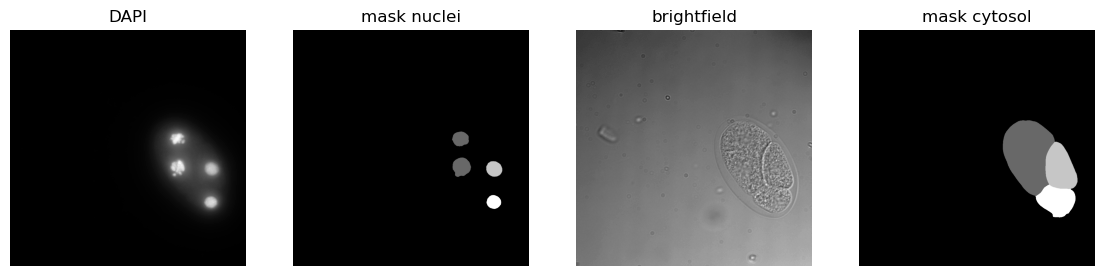

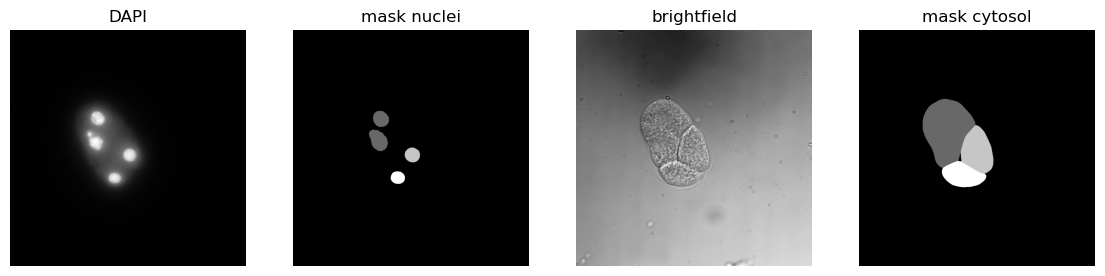

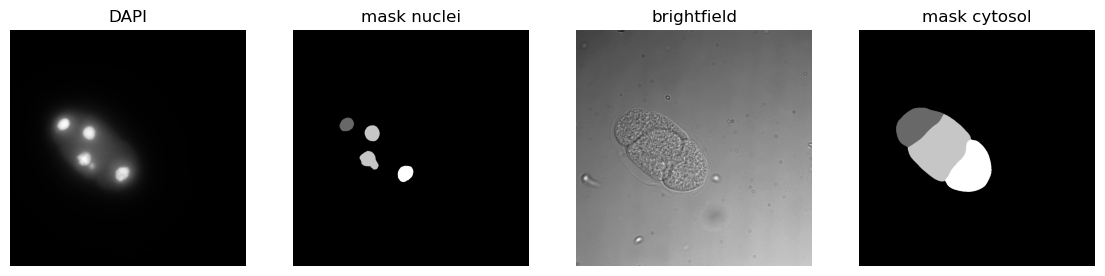

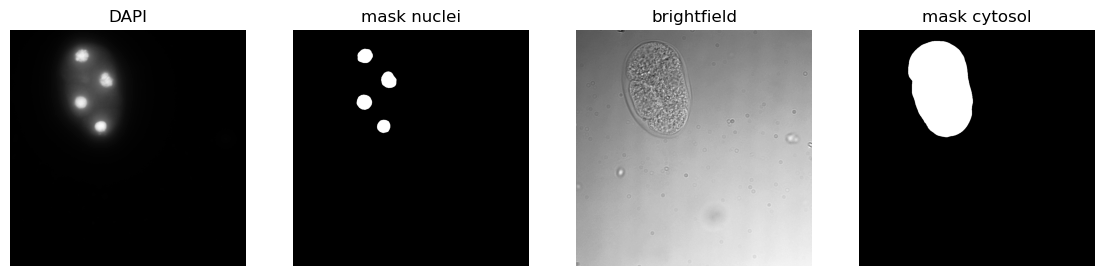

In [6]:
# Code to call the segmentation function. Works great and saves segmentation.png in the correspinding output_image_subdirectory

# Now iterate through all_image_stacks and call plot with the appropriate arguments
list_all_masks_nuc =[]
list_all_masks_cyto =[]
list_all_nuc_size =[]
list_all_cyto_size=[]

# Iterate through all_image_stacks
for i, stack_image in enumerate(all_image_stacks):
    image_colors = all_image_stacks[i][0]
    image_nuclei = np.max(image_colors[3, :, :, :], axis=0)
    image_cytosol = all_image_stacks[i][1]
    masks_cytosol, masks_nuclei, list_masks_cyto_sizes, list_masks_nuc_sizes = segmentation(image_cytosol, image_nuclei, cytosol_diameter=100, threshold_intensity_nuc_segmentation=1200)
    list_all_masks_nuc.append(masks_nuclei)
    list_all_masks_cyto.append(masks_cytosol)
    list_all_nuc_size.append(list_masks_nuc_sizes)
    list_all_cyto_size.append(list_masks_cyto_sizes)


/tmp/ipykernel_2238224/1288710352.py:85: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  filtered_cyto = morphology.remove_small_objects(masks_cytosol_unfiltered, min_size=min_size)


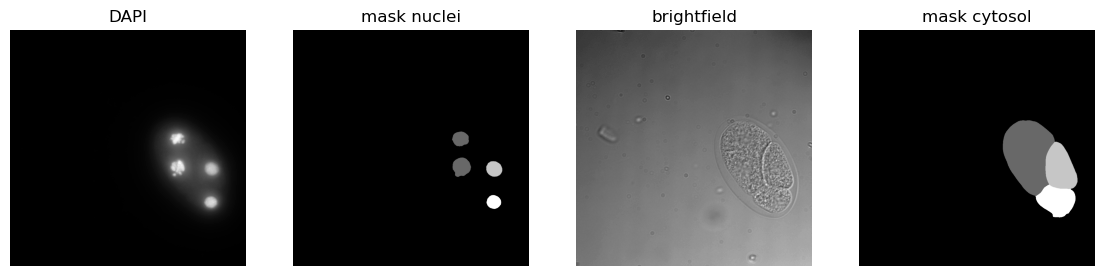

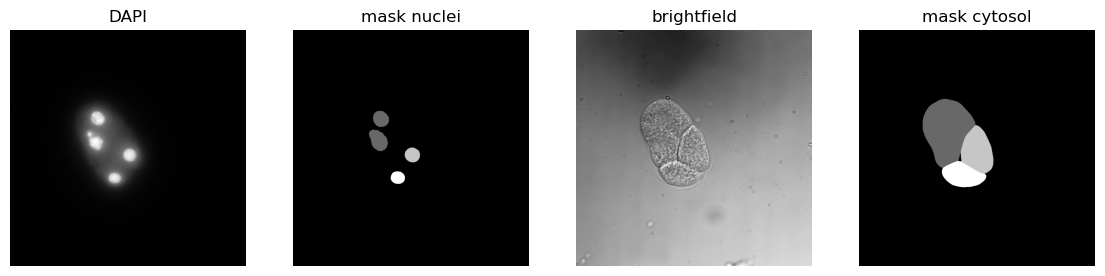

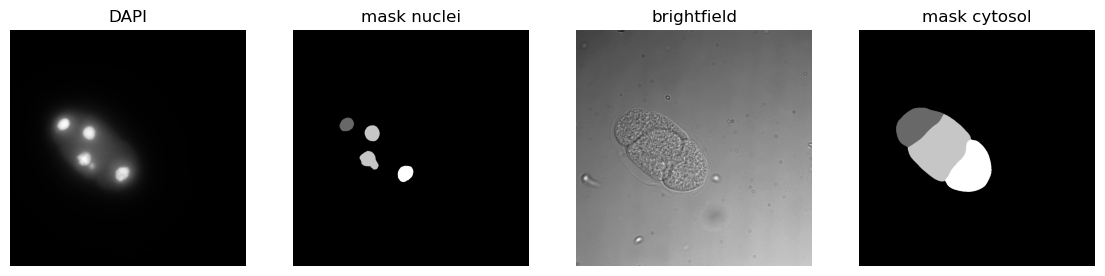

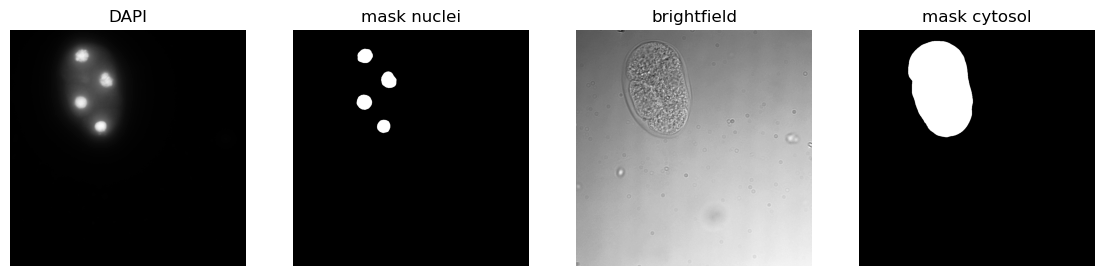

In [7]:
# Code to call the segmentation function. Works great and saves segmentation.png in the correspinding output_image_subdirectory

# Now iterate through all_image_stacks and call plot with the appropriate arguments
list_all_masks_nuc =[]
list_all_masks_cyto =[]
list_all_nuc_size =[]
list_all_cyto_size=[]

# Iterate through all_image_stacks
for i, stack_image in enumerate(all_image_stacks):
    image_colors = all_image_stacks[i][0]
    image_nuclei = np.max(image_colors[3, :, :, :], axis=0)
    image_cytosol = all_image_stacks[i][1]
    masks_cytosol, masks_nuclei, list_masks_cyto_sizes, list_masks_nuc_sizes = segmentation(image_cytosol, image_nuclei, cytosol_diameter=100, threshold_intensity_nuc_segmentation=1200)
    list_all_masks_nuc.append(masks_nuclei)
    list_all_masks_cyto.append(masks_cytosol)
    list_all_nuc_size.append(list_masks_nuc_sizes)
    list_all_cyto_size.append(list_masks_cyto_sizes)

    # Save in plots subdirectory
    image_output_directory = image_output_directories[i]

    segmentation_filename = os.path.join(image_output_directory, f"{subdirectories[i]}_segmentation.png")

    # Save the figure
    plt.savefig(segmentation_filename)

    # Close the figure to avoid overlapping with the next one
#     plt.close()

# Display the last segmentation plot (optional)
plt.show()


#### 2.2 Spot detection

In [8]:
#@title Codes used for spot detection
# Note: spot radius = Point Spread Function (PSF)
def spot_detection(rna,voxel_size,spot_radius,masks_cytosol):
    spots, threshold = detection.detect_spots(
        images= rna,
        return_threshold=True,
        voxel_size=voxel_size,
        spot_radius=spot_radius) 

    spot_radius_px = detection.get_object_radius_pixel(
        voxel_size_nm=voxel_size,
        object_radius_nm=spot_radius,
        ndim=3) 
    

    # LoG filter
    rna_log = stack.log_filter(rna, sigma=spot_radius_px)

    # local maximum detection
    mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

    # thresholding
    threshold = detection.automated_threshold_setting(rna_log, mask)
    spots, _ = detection.spots_thresholding(rna_log, mask, threshold)


    # Decompose regions by simulating as many spots as possible until we match the original region intensity.
    #spots_post_decomposition = spots.copy()
    spots_post_decomposition, dense_regions, reference_spot = detection.decompose_dense(
        image=rna,
        spots=spots,
        voxel_size=voxel_size,
        spot_radius=spot_radius,
        alpha=0.7,  # alpha impacts the number of spots per candidate region
        beta=1,  # beta impacts the number of candidate regions to decompose
        gamma=5)  # gamma the filtering step to denoise the image

    # define clusters
    spots_post_clustering, clusters = detection.detect_clusters(
        spots=spots_post_decomposition,
        voxel_size=voxel_size,
        radius=626, #626
        nb_min_spots=4)

    #plotting
    print(f"{rna_channel} detection")
    print(f" threshold: {threshold}")
    print("\r spots: {0}".format(spots_post_clustering.shape[0]))
    print("\r clusters: {0}".format(clusters.shape[0]))
    
    #elbow plot
    threshold_filename = os.path.join(output_directory + '/' + subdirectory + '_' + rna_channel +  '_threshold')
    plot.plot_elbow(
        images=rna,
        voxel_size=voxel_size,
        spot_radius=spot_radius,
        size_axes=8,
        framesize=(5, 3),
        title=(f"{rna_channel} detection threshold"),
        size_title=12,
        path_output=threshold_filename,
        show=True  # Set show to False to prevent displaying the plot
    )

    # Save the plots in the results folder
    detection_filename = os.path.join(output_directory + '/' + subdirectory + '_' + rna_channel + '_detection')
    plot.plot_detection(
        image=np.max(rna, axis=0), 
        spots=[spots_post_decomposition, clusters[:, :3]],
        shape=["circle", "polygon"],
        radius=[1.5, 4],
        color=["red", "blue"],
        linewidth=[1, 2],
        fill=[False, True],
        contrast=True,
        framesize=(4, 4),
        title=(f"{rna_channel} detection"),
        path_output=detection_filename,
        show=True
    )

    #spots_no_ts, _, ts = multistack.remove_transcription_site(spotDetectionCSV, clusterDetectionCSV, mask_nuc, ndim=3)
    #spots_in_region, _ = multistack.identify_objects_in_region(mask, spots_post_clustering[:,:3], ndim=3)

    # Separating and counting the spots in each cell
    number_masks_cyto = np.max(masks_cytosol)
    list_spots_in_each_cell =[]
    list_clusters_in_each_cell =[]
    for i in range (1, number_masks_cyto+1):
        temp_cyto_mask= np.zeros_like(masks_cytosol)
        temp_cyto_mask[masks_cytosol == i] = i
        spots_in_region, _ = multistack.identify_objects_in_region(mask=temp_cyto_mask, coord=spots_post_clustering[:,:3], ndim=3)
        clusters_in_region,_ = multistack.identify_objects_in_region(mask=temp_cyto_mask, coord=clusters[:,:3], ndim=3)
        list_spots_in_each_cell.append(len(spots_in_region))
        list_clusters_in_each_cell.append(len( clusters_in_region ))
        del spots_in_region, clusters_in_region
    return spots_post_clustering, clusters, list_spots_in_each_cell, list_clusters_in_each_cell

In [9]:
# PSF calculator 

# ch1 - mCherry channel
wavelength_mCherry = 610  # wavelength in nm
na = 1.2  # numerical aperture

# Calculate lateral PSF
fwhm_xy = 0.61 * wavelength_mCherry / na

# Calculate axial PSF
refractive_index_medium = 1.515  # refractive index of imaging medium (oil)
fwhm_z = 2 * refractive_index_medium * wavelength_mCherry / na**2

# Print the result
# print(f"Lateral (xy) PSF: {fwhm_xy} nm")

# print(f"Axial (z) PSF with 60x oil objective: {fwhm_z} nm")


# ch0 - Cy5 channel
wavelength_cy5 = 670  # wavelength in nm
na = 1.2  # numerical aperture for Cy5 channel
refractive_index_medium_cy5 = 1.515  # refractive index of imaging medium (oil) for Cy5 channel

# Calculate lateral PSF for Cy5 channel
fwhm_xy_cy5 = 0.61 * wavelength_cy5 / na

# Print the result for Cy5 channel
# print(f"Lateral (xy) PSF for Cy5 channel: {fwhm_xy_cy5} nm")

# Calculate axial PSF for Cy5 channel
fwhm_z_cy5 = 2 * refractive_index_medium_cy5 * wavelength_cy5 / na**2

# Print the result for Cy5 channel
# print(f"Axial (z) PSF for Cy5 channel with 60x oil objective: {fwhm_z_cy5} nm")



set-3 mRNA detection
 threshold: 78.0
 spots: 1269
 clusters: 0


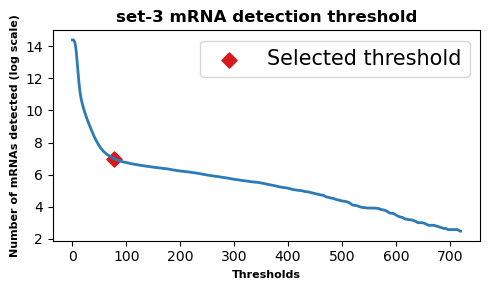

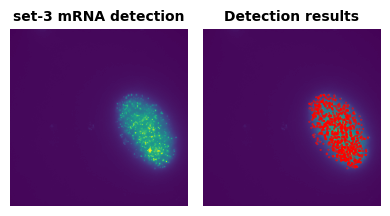

lin-41 mRNA detection
 threshold: 70.0
 spots: 1182
 clusters: 0


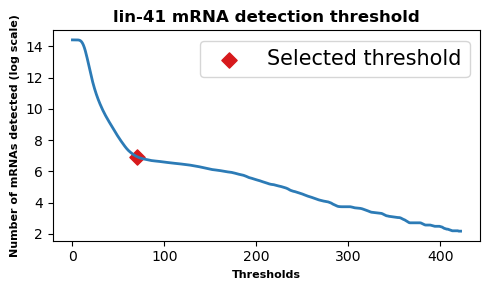

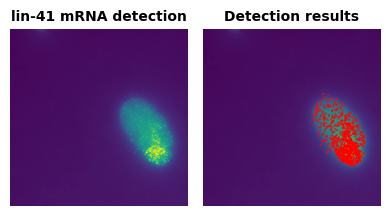

set-3 mRNA detection
 threshold: 69.0
 spots: 906
 clusters: 0


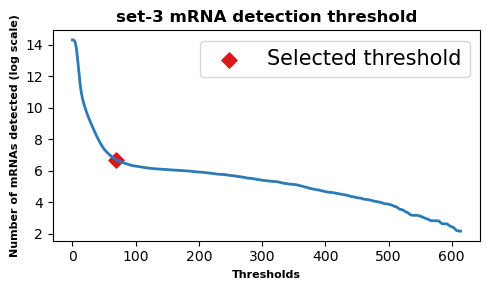

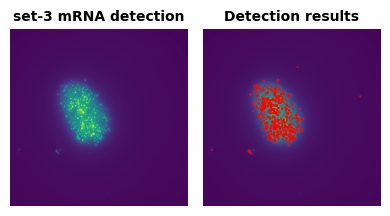

lin-41 mRNA detection
 threshold: 63.0
 spots: 534
 clusters: 0


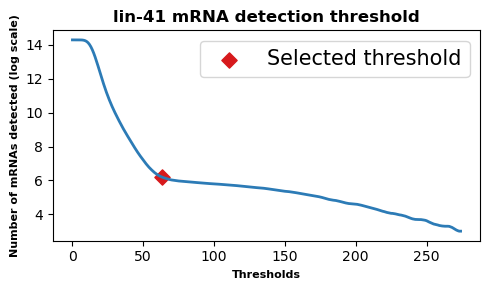

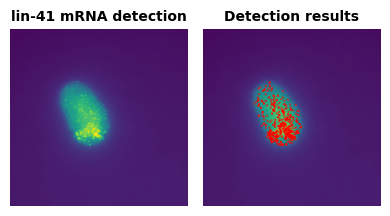

set-3 mRNA detection
 threshold: 86.0
 spots: 1272
 clusters: 0


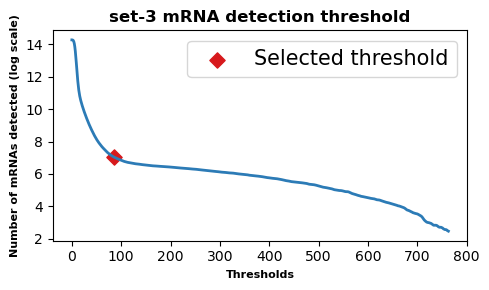

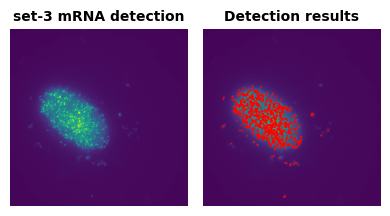

lin-41 mRNA detection
 threshold: 69.0
 spots: 1292
 clusters: 0


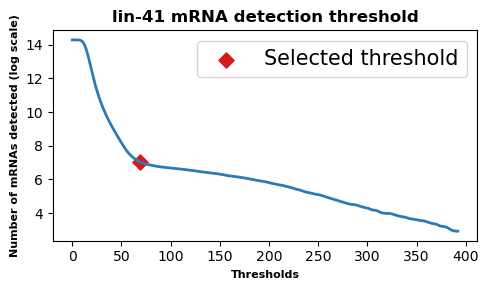

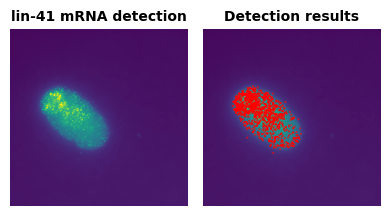

set-3 mRNA detection
 threshold: 79.0
 spots: 934
 clusters: 0


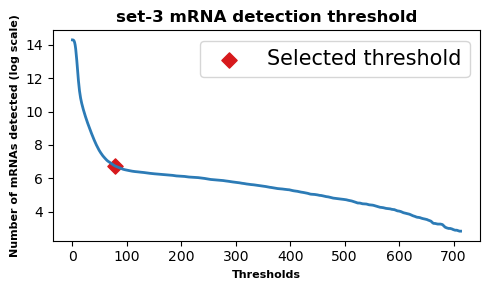

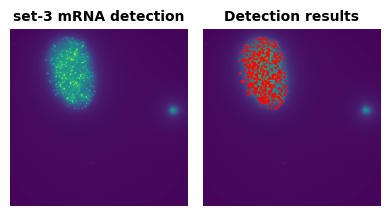

lin-41 mRNA detection
 threshold: 65.0
 spots: 836
 clusters: 0


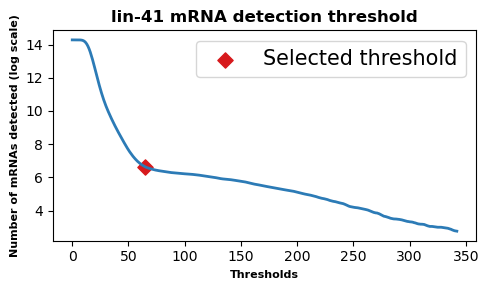

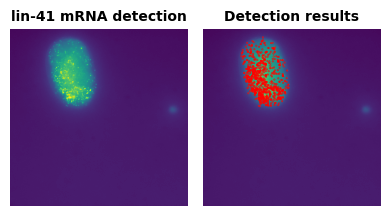

In [10]:
#I'm trying to save the elbow plot and spot detection pngs in their corresponding subdirectories in the output directory

#A voxel represents the volume of a 3D pixel and is the smallest distinguishable element in your imaging data.

# Code to call the spot detection function. 
voxel_size = (1448, 450, 450)   # Microscope pixel size Z,Y,X
spot_radius_ch0 = (1409, 340, 340)  # PSF Z,Y,X
spot_radius_ch1 = (1283, 310, 310)  # PSF Z,Y,X


# This is creating a list of lists to store the quantification for all images. 
list_all_spots_in_each_cell_ch0=[]
list_all_clusters_in_each_cell_ch0=[]
list_all_spots_in_each_cell_ch1=[]
list_all_clusters_in_each_cell_ch1=[]


image_output_directory = sorted(image_output_directories[i])
# Now iterate through all_image_stacks and call plot with the appropriate arguments
for i, stack_image in enumerate(all_image_stacks):
    image_colors = all_image_stacks[i][0]

    
    rna_ch0 = image_colors[0, :, :, :]  # [Z, Y, X, C]
    rna_channel = Cy5
    _, _, list_spots_in_each_cell_ch0, list_clusters_in_each_cell_ch0 = spot_detection(
        rna_ch0, voxel_size, spot_radius_ch0, list_all_masks_cyto[i]
    )

    rna_ch1 = image_colors[1, :, :, :]  # [Z, Y, X, C]
    rna_channel = mCherry
    _, _, list_spots_in_each_cell_ch1, list_clusters_in_each_cell_ch1 = spot_detection(
        rna_ch1, voxel_size, spot_radius_ch1, list_all_masks_cyto[i]
    )

    list_all_spots_in_each_cell_ch0.append(list_spots_in_each_cell_ch0)
    list_all_clusters_in_each_cell_ch0.append(list_clusters_in_each_cell_ch0)
    list_all_spots_in_each_cell_ch1.append(list_spots_in_each_cell_ch1)
    list_all_clusters_in_each_cell_ch1.append(list_clusters_in_each_cell_ch1)
    
    # Save in each image_output_directory
    image_output_directory = image_output_directories[i]
    subdirectory = subdirectories[i]
    plt.show()
 

In [11]:
# Calculate the sum of each list

total_spots_ch0 = [sum(sublist) for sublist in list_all_spots_in_each_cell_ch0]
total_clusters_ch0 = [sum(sublist) for sublist in list_all_clusters_in_each_cell_ch0]
total_spots_ch1 = [sum(sublist) for sublist in list_all_spots_in_each_cell_ch1]
total_clusters_ch1 = [sum(sublist) for sublist in list_all_clusters_in_each_cell_ch1]

# Initialize an empty DataFrame
df_quantification = pd.DataFrame()

# Initialize empty lists for image_names and all_data
image_names = []
all_data = []

# Iterate over subdirectory_paths
for img_index, subdirectory_path in enumerate(subdirectory_paths):
    image_name = subdirectory_path.split(os.path.sep)[-1]
    image_names.append(image_name)

    data = {
        'Image ID': image_names[img_index],
        f'{Cy5} molecules': total_spots_ch0[img_index],
        f'{mCherry} molecules': total_spots_ch1[img_index],
        f'{Cy5} clusters': total_clusters_ch0[img_index],
        f'{mCherry} clusters': total_clusters_ch1[img_index],
    }

    # Append data to the list
    all_data.append(data)

# Convert the list of data dictionaries to a DataFrame
df_quantification = pd.DataFrame(all_data)

# Set the title attribute (optional)
df_quantification.title = folder_name

# Save as .csv
quantification_output = os.path.join(output_directory, 'quantification_' + folder_name + '.csv')
df_quantification.to_csv(quantification_output, index=False)

# Optionally, you can assign path_output to quantification_output if needed
path_output = quantification_output

# Print the title
print(f'Experiment ID: {folder_name}\n')

# Display the DataFrame (optional)
df_quantification


Experiment ID: 230521_N2_lin-41_set-3_rep1_4-cell



,Image ID,set-3 mRNA molecules,lin-41 mRNA molecules,set-3 mRNA clusters,lin-41 mRNA clusters
0,05,1191,1177,0,0
1,06,873,531,0,0
2,08,1206,1285,0,0
3,11,904,829,0,0


#### 2.3 Data collection and visualization

/tmp/ipykernel_2238224/3165930904.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="mRNA", y="number_spots", data=df, inner=None, color="lightgray", scale="width", palette="pastel")
/tmp/ipykernel_2238224/3165930904.py:20: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x="mRNA", y="number_spots", data=df, inner=None, color="lightgray", scale="width", palette="pastel")


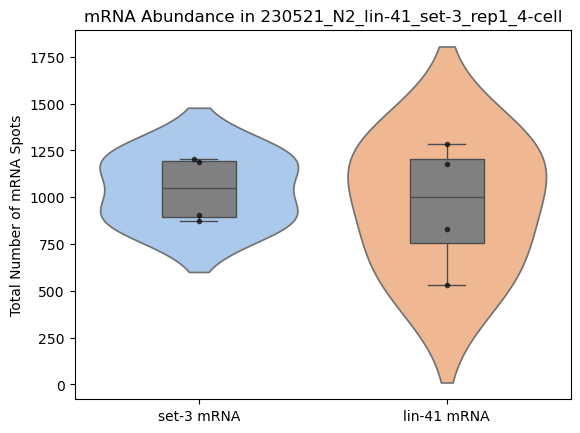

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Create a dictionary with the given data
list_all_spots_ch0 = total_spots_ch0
list_all_spots_ch1 = total_spots_ch1

data = {
    'mRNA': [C0] * len(list_all_spots_ch0) + [C1] * len(list_all_spots_ch1),
    'number_spots': list_all_spots_ch0 + list_all_spots_ch1
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create a violin plot, boxplot, and swarmplot
sns.violinplot(x="mRNA", y="number_spots", data=df, inner=None, color="lightgray", scale="width", palette="pastel")
sns.boxplot(x="mRNA", y="number_spots", data=df, color="gray", width=0.3, showfliers=False)
sns.swarmplot(x="mRNA", y="number_spots", data=df, color="black", size=4, alpha=0.7)

# Include folder_name in the title
plt.title(f"mRNA Abundance in {folder_name}")

# # Set y-axis limits
# plt.ylim(0,6000)

# Customize axis labels
plt.xlabel("")
plt.ylabel("Total Number of mRNA Spots")

# Save as .png
# Define the output path before saving the PNG
violin_output = os.path.join(output_directory, f'violin_{folder_name}.png')
plt.savefig(violin_output)

# Display the plot
plt.show()


In [13]:

# # Create a dictionary with the given data
# list_all_spots_ch0 = total_spots_ch0
# list_all_spots_ch1 = total_spots_ch1

# # Apply a base-10 log transformation (log10) to the data
# list_all_spots_ch0_log = [np.log10(x) for x in list_all_spots_ch0]
# list_all_spots_ch1_log = [np.log10(x) for x in list_all_spots_ch1]

# data = {
#     'mRNA': ['set-3'] * len(list_all_spots_ch0) + ['lin-41'] * len(list_all_spots_ch1),
#     'log10_number_spots': list_all_spots_ch0_log + list_all_spots_ch1_log
# }

# # Create a DataFrame
# df = pd.DataFrame(data)

# # Create a violin plot with a log10-scaled y-axis
# sns.violinplot(x="mRNA", y="log10_number_spots", data=df)
# plt.ylabel("log10(Number of mRNA molecules)")
# # plt.title("mRNA Abundance Comparison ({Cy5} vs. {mCherry}) - Log10 Scale")
# plt.title(f"mRNA Abundance Comparison ({Cy5} vs. {mCherry}) - Log10 Scale")


# #save as .csv
# # Define the output path before saving the CSV
# violin_output = os.path.join(output_directory, 'violin_' + folder_name + '.png')
# plt.savefig(violin_output)

# # Display the plot
# plt.show()
